In [9]:
# -*- coding:utf-8 -*-
# Author:凌逆战 | Never
# Date: 2021/12/6
"""
kernel_size改为了(3,5)
没有添加dropout
"""
import torch
import torch.nn as nn


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, causal=False):
        super(DepthwiseSeparableConv, self).__init__()
        # Use `groups` option to implement depthwise convolution
        depthwise_conv = nn.Conv1d(in_channels, in_channels, kernel_size, stride=stride, padding=padding,
                                   dilation=dilation, groups=in_channels, bias=False)

        pointwise_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        if causal:
            self.net = nn.Sequential(depthwise_conv,
                                     Chomp1d(padding),
                                     nn.PReLU(),
                                     nn.BatchNorm1d(in_channels),
                                     pointwise_conv)
        else:
            self.net = nn.Sequential(depthwise_conv,
                                     nn.PReLU(),
                                     nn.BatchNorm1d(in_channels),
                                     pointwise_conv)

    def forward(self, x):
        return self.net(x)


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(ResBlock, self).__init__()

        self.TCM_net = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
            nn.PReLU(num_parameters=1),
            nn.BatchNorm1d(num_features=out_channels),
            DepthwiseSeparableConv(in_channels=out_channels, out_channels=in_channels, kernel_size=kernel_size,
                                   stride=1,
                                   padding=(kernel_size - 1) * dilation, dilation=dilation, causal=True)
        )

    def forward(self, input):
        x = self.TCM_net(input)
        return x + input


class TCNN_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, init_dilation=3, num_layers=6):
        super(TCNN_Block, self).__init__()
        layers = []
        for i in range(num_layers):
            dilation_size = init_dilation ** i
            # in_channels = in_channels if i == 0 else out_channels

            layers += [ResBlock(in_channels, out_channels,
                                kernel_size, dilation=dilation_size)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class DConv2d_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
        super(DConv2d_block, self).__init__()
        self.DConv2d = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=kernel_size, stride=stride, padding=padding,
                               output_padding=output_padding),
            nn.BatchNorm2d(num_features=out_channels),
            nn.PReLU()
        )
        self.drop = nn.Dropout(0.2)

    def forward(self, encode, decode):
        encode = self.drop(encode)
        skip_connection = torch.cat((encode, decode), dim=1)
        DConv2d = self.DConv2d(skip_connection)

        return DConv2d


# input: (B, 1, T, 320)    T为帧数，320为帧长
class TCNN(nn.Module):
    def __init__(self):
        super(TCNN, self).__init__()
        self.Conv2d_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2)),
            nn.BatchNorm2d(num_features=16),
            nn.PReLU()
        )

        self.Conv2d_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 5), stride=(1, 2), padding=(1, 2)),
            nn.BatchNorm2d(num_features=16),
            nn.PReLU()
        )

        self.Conv2d_3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 5), stride=(1, 2), padding=(1, 1)),
            nn.BatchNorm2d(num_features=16),
            nn.PReLU()
        )

        self.Conv2d_4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 5), stride=(1, 2), padding=(1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.PReLU()
        )

        self.Conv2d_5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 5), stride=(1, 2), padding=(1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.PReLU()
        )
        self.Conv2d_6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 5), stride=(1, 2), padding=(1, 1)),
            nn.BatchNorm2d(num_features=64),
            nn.PReLU()
        )
        self.Conv2d_7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 5), stride=(1, 2), padding=(1, 1)),
            nn.BatchNorm2d(num_features=64),
            nn.PReLU()
        )
        self.TCNN_Block_1 = TCNN_Block(in_channels=256, out_channels=512, kernel_size=3, init_dilation=2, num_layers=6)
        self.TCNN_Block_2 = TCNN_Block(in_channels=256, out_channels=512, kernel_size=3, init_dilation=2, num_layers=6)
        self.TCNN_Block_3 = TCNN_Block(in_channels=256, out_channels=512, kernel_size=3, init_dilation=2, num_layers=6)

        self.DConv2d_7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 5), stride=(1, 2), padding=(1, 1),
                               output_padding=(0, 0)),
            nn.BatchNorm2d(num_features=64),
            nn.PReLU()
        )
        self.DConv2d_6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=(3, 5), stride=(1, 2), padding=(1, 1),
                               output_padding=(0, 0)),
            nn.BatchNorm2d(num_features=32),
            nn.PReLU()
        )
        self.DConv2d_5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 5), stride=(1, 2), padding=(1, 1),
                               output_padding=(0, 0)),
            nn.BatchNorm2d(num_features=32),
            nn.PReLU()
        )
        self.DConv2d_4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=(3, 5), stride=(1, 2), padding=(1, 1),
                               output_padding=(0, 0)),
            nn.BatchNorm2d(num_features=16),
            nn.PReLU()
        )
        self.DConv2d_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 5), stride=(1, 2), padding=(1, 1),
                               output_padding=(0, 1)),
            nn.BatchNorm2d(num_features=16),
            nn.PReLU()
        )
        self.DConv2d_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 5), stride=(1, 2), padding=(1, 2),
                               output_padding=(0, 1)),
            nn.BatchNorm2d(num_features=16),
            nn.PReLU()
        )
        self.DConv2d_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2),
                               output_padding=(0, 0)),
            nn.BatchNorm2d(num_features=1),
            nn.PReLU()
        )

    def forward(self, input):
        Conv2d_1 = self.Conv2d_1(input)
        # print("Conv2d_1", Conv2d_1.shape)  # [64, 16, 5, 320]
        Conv2d_2 = self.Conv2d_2(Conv2d_1)
        # print("Conv2d_2", Conv2d_2.shape)  # [64, 16, 5, 160]
        Conv2d_3 = self.Conv2d_3(Conv2d_2)
        # print("Conv2d_3", Conv2d_3.shape)  # [64, 16, 5, 79]
        Conv2d_4 = self.Conv2d_4(Conv2d_3)
        # print("Conv2d_4", Conv2d_4.shape)  # [64, 32, 5, 39]
        Conv2d_5 = self.Conv2d_5(Conv2d_4)
        # print("Conv2d_5", Conv2d_5.shape)  # [64, 32, 5, 19]
        Conv2d_6 = self.Conv2d_6(Conv2d_5)
        # print("Conv2d_6", Conv2d_6.shape)  # [64, 64, 5, 9]
        Conv2d_7 = self.Conv2d_7(Conv2d_6)
        # print("Conv2d_7", Conv2d_7.shape)  # [64, 64, 5, 4] (B, 1, T, 320)
        reshape_1 = Conv2d_7.permute(0, 1, 3, 2)  # [64, 64, 4, 5] (B,C,帧长,帧数)
        batch_size, C, frame_len, frame_num = reshape_1.shape
        reshape_1 = reshape_1.reshape(batch_size, C * frame_len, frame_num)
        # print("reshape_1", reshape_1.shape)  # [64, 256, 5]

        TCNN_Block_1 = self.TCNN_Block_1(reshape_1)
        TCNN_Block_2 = self.TCNN_Block_2(TCNN_Block_1)
        TCNN_Block_3 = self.TCNN_Block_3(TCNN_Block_2)

        reshape_2 = TCNN_Block_3.reshape(batch_size, C, frame_len, frame_num)
        reshape_2 = reshape_2.permute(0, 1, 3, 2)
        # print("reshape_2", reshape_2.shape)  # [64, 64, 5, 4]

        DConv2d_7 = self.DConv2d_7(torch.cat((Conv2d_7, reshape_2), dim=1))
        # print("DConv2d_7", DConv2d_7.shape)     # [64, 64, 5, 9]
        DConv2d_6 = self.DConv2d_6(torch.cat((Conv2d_6, DConv2d_7), dim=1))
        # print("DConv2d_6", DConv2d_6.shape)     # [64, 32, 5, 19]
        DConv2d_5 = self.DConv2d_5(torch.cat((Conv2d_5, DConv2d_6), dim=1))
        # print("DConv2d_5", DConv2d_5.shape)     # [64, 32, 5, 39]
        DConv2d_4 = self.DConv2d_4(torch.cat((Conv2d_4, DConv2d_5), dim=1))
        # print("DConv2d_4", DConv2d_4.shape)     # [64, 16, 5, 79]
        DConv2d_3 = self.DConv2d_3(torch.cat((Conv2d_3, DConv2d_4), dim=1))
        # print("DConv2d_3", DConv2d_3.shape)     # [64, 16, 5, 160]
        DConv2d_2 = self.DConv2d_2(torch.cat((Conv2d_2, DConv2d_3), dim=1))
        # print("DConv2d_2", DConv2d_2.shape)     # [64, 16, 5, 320]
        DConv2d_1 = self.DConv2d_1(torch.cat((Conv2d_1, DConv2d_2), dim=1))
        # print("DConv2d_1", DConv2d_1.shape)     # [64, 1, 5, 320]

        return DConv2d_1


if __name__ == "__main__":
    # x = torch.randn(64, 32, 8192)
    # model = TCNN_Block(in_channels=32, out_channels=64, kernel_size=3, init_dilation=3, num_layers=6)  # 输出 (64, 1, 8192)

    x = torch.randn(64, 1, 5, 320)
    model = TCNN()

    # x = torch.randn(64, 32, 256)
    # model = DepthwiseSeparableConv(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=4, dilation=2,
    #                                causal=True)

    y = model(x)
    print("input", x.shape)
    print("output", y.shape)  # output torch.Size([64, 1, 8192])

input torch.Size([64, 1, 5, 320])
output torch.Size([64, 1, 5, 320])


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
import numpy as np

# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Modify TCNN for text classification
class TextTCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=768, num_classes=2):
        super(TextTCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Use your existing TCNN architecture
        self.tcnn = TCNN()
        
        # Add classification head
        self.classifier = nn.Sequential(
            nn.Linear(320, 128),  # 320 is from your original model's output
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        # Reshape for TCNN (B, 1, T, embedding_dim)
        embedded = embedded.unsqueeze(1)
        
        # Pass through TCNN
        tcnn_output = self.tcnn(embedded)
        
        # Global average pooling
        pooled = torch.mean(tcnn_output, dim=(2, 3))
        
        # Classification
        output = self.classifier(pooled)
        return output

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device='cuda'):
    model = model.to(device)
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct / total
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask)
                _, predicted = torch.max(outputs.data, 1)
                
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * val_correct / val_total
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {total_loss/len(train_loader):.4f}')
        print(f'Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        print('--------------------')
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

def main():
    # Load and preprocess data
    df = pd.read_csv('train.csv')
    
    # Clean the text data
    df['sentence'] = df['sentence'].str.replace('b\'', '').str.replace('\'', '')
    
    # Split the data
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df['sentence'].values, 
        df['target'].values,
        test_size=0.2,
        random_state=42
    )
    
    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Create datasets
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    
    # Initialize model
    model = TextTCNN(
        vocab_size=tokenizer.vocab_size,
        embedding_dim=768,  # BERT's embedding dimension
        num_classes=2
    )
    
    # Training parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    
    # Train the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device=device)

if __name__ == '__main__':
    main()

/Users/parthpsg/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/parthpsg/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: Given groups=1, weight of size [512, 256, 1], expected input[32, 704, 128] to have 256 channels, but got 704 channels instead

[nltk_data] Downloading package punkt to /Users/parthpsg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch 1/5 - Loss: 0.4835 - Acc: 0.8747
Epoch 2/5 - Loss: 0.2576 - Acc: 0.9391
Epoch 3/5 - Loss: 0.1819 - Acc: 0.9358
Epoch 4/5 - Loss: 0.1391 - Acc: 0.9707
Epoch 5/5 - Loss: 0.1104 - Acc: 0.9723

Cluster 0:
["b'like a giant commercial for universal studios , where much of the action takes place '", 'b"like the english patient and the unbearable lightness of being , the hours is one of those reputedly `` unfilmable \'\' novels that has bucked the odds to emerge as an exquisite motion picture in its own right . "', "b'admire this film for its harsh objectivity and refusal to seek our tears , our sympathies . '", "b'the campaign-trail press '", 'b"\'s suspenseful enough for older kids but not too scary "', "b'than a leaky freighter '", "b'a wonderful tale '", "b'exhausted , desiccated talent '", "b'cold-hearted '", "b'french director anne fontaine delivers an inspired portrait of male-ridden angst and the emotional blockage that accompanies this human condition '"]

Cluster 1:
["b'compass

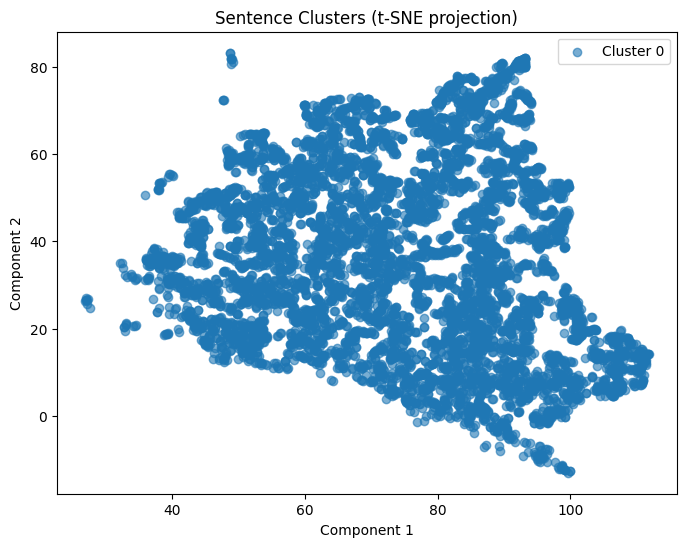

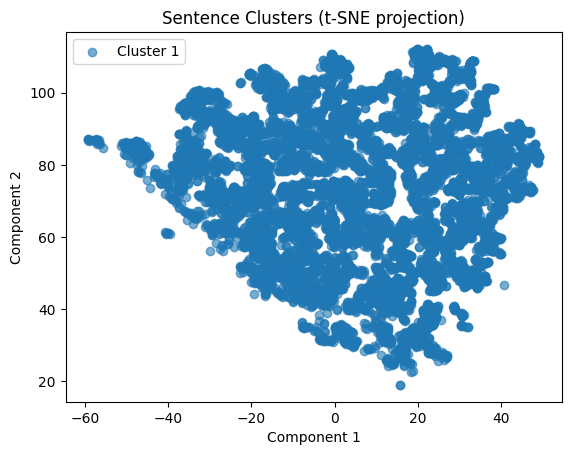

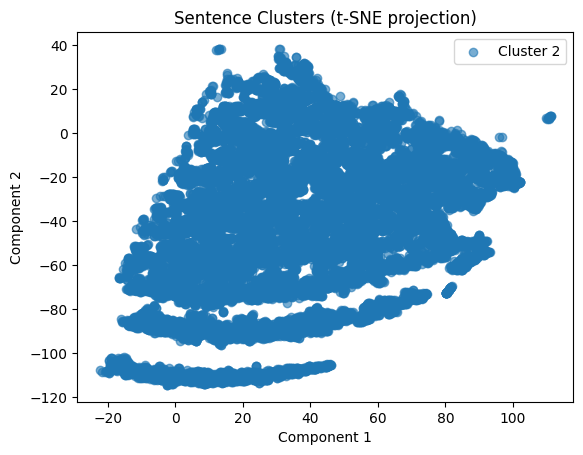

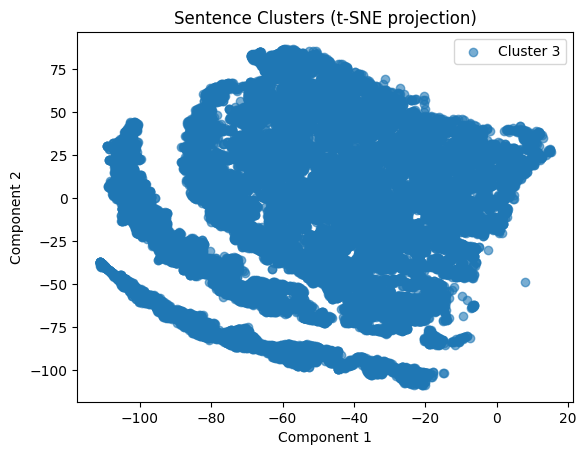


Cluster 0:
["b'like a giant commercial for universal studios , where much of the action takes place '", 'b"like the english patient and the unbearable lightness of being , the hours is one of those reputedly `` unfilmable \'\' novels that has bucked the odds to emerge as an exquisite motion picture in its own right . "', "b'admire this film for its harsh objectivity and refusal to seek our tears , our sympathies . '", "b'the campaign-trail press '", 'b"\'s suspenseful enough for older kids but not too scary "', "b'than a leaky freighter '", "b'a wonderful tale '", "b'exhausted , desiccated talent '", "b'cold-hearted '", "b'french director anne fontaine delivers an inspired portrait of male-ridden angst and the emotional blockage that accompanies this human condition '"]

Cluster 1:
["b'compassion , sacrifice , '", 'b"it could have been something special , but two things drag it down to mediocrity -- director clare peploe \'s misunderstanding of marivaux \'s rhythms , and mira sorvino 

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

nltk.download('punkt')

# 1. Data Preparation
class SSTDataset(Dataset):
    def __init__(self, csv_path, vocab=None, max_len=32):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].apply(lambda x: x.replace("b'", "").replace("'", "")).tolist()
        self.labels = df['target'].tolist()
        self.max_len = max_len

        # Build vocab if not provided
        if vocab is None:
            all_tokens = [word_tokenize(s.lower()) for s in self.sentences]
            flat_tokens = [item for sublist in all_tokens for item in sublist]
            freq = Counter(flat_tokens)
            self.vocab = {w: i+2 for i, (w, _) in enumerate(freq.most_common())}
            self.vocab['<PAD>'] = 0
            self.vocab['<UNK>'] = 1
        else:
            self.vocab = vocab

        self.encoded = [self.encode(s) for s in self.sentences]

    def encode(self, sentence):
        tokens = word_tokenize(sentence.lower())
        ids = [self.vocab.get(w, self.vocab['<UNK>']) for w in tokens]
        if len(ids) < self.max_len:
            ids += [self.vocab['<PAD>']] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]
        return ids

    def __len__(self):
        return len(self.encoded)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# 2. TCNN Model for Sentence Embedding
class TCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, tcnn_channels=128, kernel_size=3, num_classes=2):
        super(TCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(emb_dim, tcnn_channels, kernel_size, padding=1)
        self.prelu1 = nn.PReLU()
        self.bn1 = nn.BatchNorm1d(tcnn_channels)
        self.conv2 = nn.Conv1d(tcnn_channels, tcnn_channels, kernel_size, padding=1)
        self.prelu2 = nn.PReLU()
        self.bn2 = nn.BatchNorm1d(tcnn_channels)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(tcnn_channels, num_classes)

    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, emb_dim)
        x = x.transpose(1, 2)  # (batch, emb_dim, seq_len)
        x = self.prelu1(self.bn1(self.conv1(x)))
        x = self.prelu2(self.bn2(self.conv2(x)))
        pooled = self.pool(x).squeeze(-1)  # (batch, tcnn_channels)
        logits = self.classifier(pooled)
        return logits, pooled  # Return both for clustering

# 3. Training Loop
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return accuracy_score(all_labels, all_preds)

# 4. Main Script

    # Hyperparameters
csv_path = 'train.csv'
batch_size = 64
emb_dim = 128
tcnn_channels = 128
num_classes = 2
epochs = 5
max_len = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Dataset and DataLoader
dataset = SSTDataset(csv_path, max_len=max_len)
vocab_size = len(dataset.vocab)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model, Loss, Optimizer
model = TCNN(vocab_size, emb_dim, tcnn_channels, kernel_size=3, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training
for epoch in range(epochs):
    loss = train(model, train_loader, optimizer, criterion, device)
    acc = evaluate(model, train_loader, device)
    print(f'Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Acc: {acc:.4f}')

    # 5. Extract Embeddings for Clustering
model.eval()
all_embeddings = []
all_sentences = []
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _, pooled = model(x)
        all_embeddings.append(pooled.cpu().numpy())
all_embeddings = np.concatenate(all_embeddings, axis=0)

    # 6. Clustering
n_clusters = 4  # You can change this
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(all_embeddings)

    # 7. Output clustered sentences
df = pd.read_csv(csv_path)
df['cluster'] = clusters
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['sentence'].head(10).tolist())

    

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    idx = df['cluster'] == i
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f'Cluster {i}', alpha=0.6)
    plt.legend()
    plt.title('Sentence Clusters (t-SNE projection)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['sentence'].head(10).tolist())


[nltk_data] Downloading package punkt to /Users/parthpsg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch 1/5 - Loss: 0.4803 - Acc: 0.8868
Epoch 2/5 - Loss: 0.2595 - Acc: 0.9360
Epoch 3/5 - Loss: 0.1819 - Acc: 0.9571
Epoch 4/5 - Loss: 0.1411 - Acc: 0.9703
Epoch 5/5 - Loss: 0.1111 - Acc: 0.9773

Cluster 0:
["b'for the uninitiated plays better on video with the sound '", 'b"like the english patient and the unbearable lightness of being , the hours is one of those reputedly `` unfilmable \'\' novels that has bucked the odds to emerge as an exquisite motion picture in its own right . "', "b'nothing like love to give a movie a b-12 shot '", "b'moral favorite '", "b'the campaign-trail press '", 'b"is better than ` shindler \'s list \' "', "b'observations on the human condition '", "b'ends up delivering in good measure '", "b'in his u.s. debut , mr. schnitzler proves himself a deft pace master and stylist . '", "b'that bring the routine day to day struggles of the working class to life '"]

Cluster 1:
["b'teaming '", 'b"it could have been something special , but two things drag it down to m

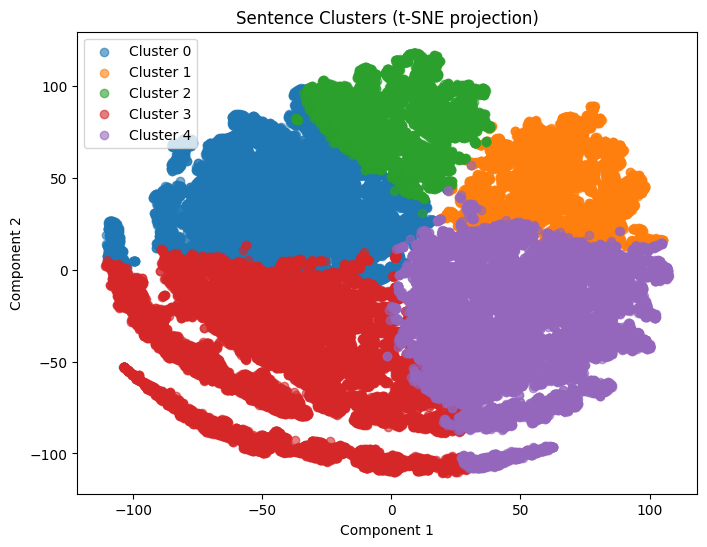


Cluster 0:
["b'for the uninitiated plays better on video with the sound '", 'b"like the english patient and the unbearable lightness of being , the hours is one of those reputedly `` unfilmable \'\' novels that has bucked the odds to emerge as an exquisite motion picture in its own right . "', "b'nothing like love to give a movie a b-12 shot '", "b'moral favorite '", "b'the campaign-trail press '", 'b"is better than ` shindler \'s list \' "', "b'observations on the human condition '", "b'ends up delivering in good measure '", "b'in his u.s. debut , mr. schnitzler proves himself a deft pace master and stylist . '", "b'that bring the routine day to day struggles of the working class to life '"]

Cluster 1:
["b'teaming '", 'b"it could have been something special , but two things drag it down to mediocrity -- director clare peploe \'s misunderstanding of marivaux \'s rhythms , and mira sorvino \'s limitations as a classical actress "', 'b"moonlight mile does n\'t quite go the distance but

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

nltk.download('punkt')

class SSTDataset(Dataset):
    def __init__(self, csv_path, vocab=None, max_len=32):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].apply(lambda x: x.replace("b'", "").replace("'", "")).tolist()
        self.labels = df['target'].tolist()
        self.max_len = max_len

        if vocab is None:
            all_tokens = [word_tokenize(s.lower()) for s in self.sentences]
            flat_tokens = [item for sublist in all_tokens for item in sublist]
            freq = Counter(flat_tokens)
            self.vocab = {w: i+2 for i, (w, _) in enumerate(freq.most_common())}
            self.vocab['<PAD>'] = 0
            self.vocab['<UNK>'] = 1
        else:
            self.vocab = vocab

        self.encoded = [self.encode(s) for s in self.sentences]

    def encode(self, sentence):
        tokens = word_tokenize(sentence.lower())
        ids = [self.vocab.get(w, self.vocab['<UNK>']) for w in tokens]
        if len(ids) < self.max_len:
            ids += [self.vocab['<PAD>']] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]
        return ids

    def __len__(self):
        return len(self.encoded)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# 2. TCNN Model for Sentence Embedding
class TCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, tcnn_channels=128, kernel_size=3, num_classes=2):
        super(TCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(emb_dim, tcnn_channels, kernel_size, padding=1)
        self.prelu1 = nn.PReLU()
        self.bn1 = nn.BatchNorm1d(tcnn_channels)
        self.conv2 = nn.Conv1d(tcnn_channels, tcnn_channels, kernel_size, padding=1)
        self.prelu2 = nn.PReLU()
        self.bn2 = nn.BatchNorm1d(tcnn_channels)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(tcnn_channels, num_classes)

    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, emb_dim)
        x = x.transpose(1, 2)  # (batch, emb_dim, seq_len)
        x = self.prelu1(self.bn1(self.conv1(x)))
        x = self.prelu2(self.bn2(self.conv2(x)))
        pooled = self.pool(x).squeeze(-1)  # (batch, tcnn_channels)
        logits = self.classifier(pooled)
        return logits, pooled  # Return both for clustering

# 3. Training Loop
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return accuracy_score(all_labels, all_preds)

# 4. Main Script
    # Hyperparameters
csv_path = 'train.csv'
batch_size = 64
emb_dim = 128
tcnn_channels = 128
num_classes = 2
epochs = 5
max_len = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Dataset and DataLoader
dataset = SSTDataset(csv_path, max_len=max_len)
vocab_size = len(dataset.vocab)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model, Loss, Optimizer
model = TCNN(vocab_size, emb_dim, tcnn_channels, kernel_size=3, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training
for epoch in range(epochs):
    loss = train(model, train_loader, optimizer, criterion, device)
    acc = evaluate(model, train_loader, device)
    print(f'Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Acc: {acc:.4f}')

    # 5. Extract Embeddings for Clustering
model.eval()
all_embeddings = []
all_sentences = []
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _, pooled = model(x)
        all_embeddings.append(pooled.cpu().numpy())
all_embeddings = np.concatenate(all_embeddings, axis=0)

    # 6. Clustering
n_clusters = 5  # You can change this
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(all_embeddings)

    # 7. Output clustered sentences
df = pd.read_csv(csv_path)
df['cluster'] = clusters
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['sentence'].head(10).tolist())

    

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    idx = df['cluster'] == i
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f'Cluster {i}', alpha=0.6)
    plt.legend()
    plt.title('Sentence Clusters (t-SNE projection)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

plt.show()

for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['sentence'].head(10).tolist())